In [1]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

from time import time

import numpy as np 
np.random.seed(1234)

import tensorflow as tf
tf.random.set_seed(1234)

import gpflow
gpflow.config.set_default_float(np.float32)
gpflow.config.set_default_jitter(1e-2)

from sgptools.methods import *
from sgptools.kernels import get_kernel
from sgptools.utils.tsp import *
from sgptools.utils.misc import *
from sgptools.utils.metrics import *
from sgptools.utils.data import Dataset
from sgptools.utils.gpflow import get_model_params

2026-01-09 15:28:27.870970: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-09 15:28:27.871402: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-09 15:28:27.873089: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-09 15:28:27.878267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767994107.887339  612934 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767994107.88

In [2]:
def get_grid(X_data, num_x, num_y):
    grid_x, grid_y = np.mgrid[min(X_data[:, 0]):max(X_data[:, 0]):complex(num_x), 
                              min(X_data[:, 1]):max(X_data[:, 1]):complex(num_y)]
    X_grid = np.stack([grid_x, grid_y], axis=-1)
    return X_grid.reshape(-1, 2).astype(X_data.dtype)

In [3]:
# Load data
data = np.load("N17E073.npy")

# Get dataset
dataset = Dataset(data=data, dtype=np.float32,
                  num_train=1000)
del data
X_train, y_train = dataset.get_train()

# Generate X_test
x_dim, y_dim = 100, 100
X_grid = get_grid(X_train, x_dim, y_dim)
X_grid, y_grid = dataset.get_sensor_data(X_grid,
                                         max_samples=len(X_grid))
print("Grid Set Dims:", X_grid.shape)

# Get the extent for potting
extent = [min(X_train[:, 0]), max(X_train[:, 0]), 
          min(X_train[:, 1]), max(X_train[:, 1])]

Original dataset shape: (360, 360)
Training data shapes (X, y): (1000, 2), (1000, 1)
Testing data shapes (X, y): (2500, 2), (2500, 1)
Candidate data shape (X): (150, 2)
Dataset loaded and preprocessed successfully.
Grid Set Dims: (10000, 2)


W0000 00:00:1767994110.739678  612934 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


╒════════════════════════════╤══════════════════╤══════════════════╤═════════╤═════════════╤══════════╤═════════╤══════════════════════════════════════════╕
│ name                       │ class            │ transform        │ prior   │ trainable   │ shape    │ dtype   │ value                                    │
╞════════════════════════════╪══════════════════╪══════════════════╪═════════╪═════════════╪══════════╪═════════╪══════════════════════════════════════════╡
│ GPR.kernel._free_amplitude │ ResourceVariable │                  │         │ True        │ ()       │ float32 │ 1.06269                                  │
├────────────────────────────┼──────────────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼──────────────────────────────────────────┤
│ GPR.kernel.lengthscales    │ ResourceVariable │                  │         │ False       │ (10,)    │ float32 │ [1., 2., 3....                           │
├────────────────────────────┼──────────────────┼─────────

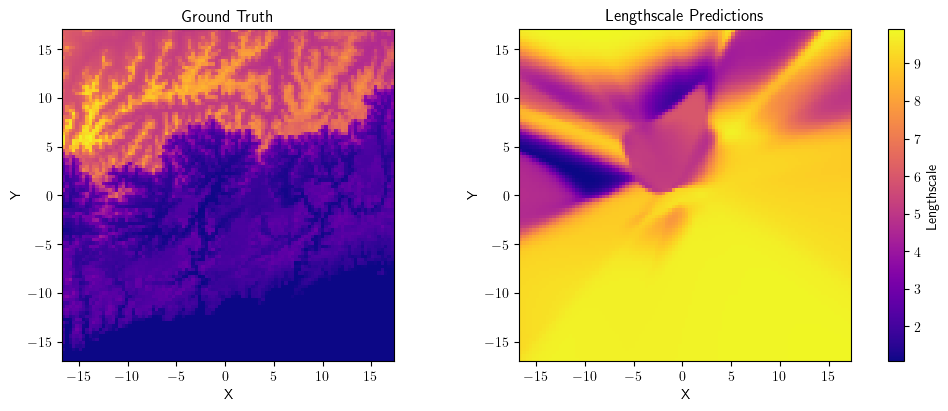

In [4]:
# Get lengthscales
_, noise_variance, kernel, model = get_model_params(
    X_train=X_train, y_train=y_train, 
    kernel=get_kernel('Attentive')(np.linspace(1, 10, 10)),
    optimizer='tf.Nadam',
    learning_rate=1e-2,
    max_steps=1000,
    return_model=True,
    verbose=True)
ls_grid = kernel.get_lengthscales(X_grid)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), 
                         constrained_layout=True)

# First subplot — training data
sc1 = axes[0].imshow(y_grid.reshape(x_dim, y_dim).T,
                     extent=extent, origin="lower",
                     cmap='plasma')
axes[0].set_title("Ground Truth")
axes[0].set_aspect('equal')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')

# Second subplot — test data
sc2 = axes[1].imshow(ls_grid.reshape(x_dim, y_dim).T, 
                     extent=extent, origin="lower",
                     cmap='plasma')
axes[1].set_title("Lengthscale Predictions")
axes[1].set_aspect('equal')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')

# Shared colorbar
fig.colorbar(sc2, ax=axes, orientation='vertical', 
             fraction=0.05, pad=0.04, label='Lengthscale')

plt.show()

Lawnmower; Distance: 1047 m; Mean Variance: 0.02


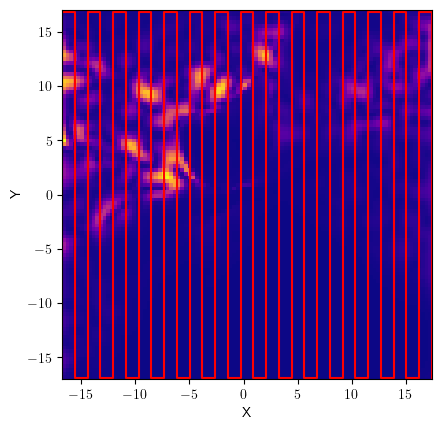

In [5]:
method = 'Lawnmower'

x_coords = np.linspace(extent[0], extent[1], 30)
y_low, y_high = extent[2]+0.1, extent[3]-0.2
y_pairs = np.array([[y_low, y_high] if (i % 2 == 0) else [y_high, y_low]
                    for i in range(len(x_coords))])   # (Nx, 2)
x_pairs = np.repeat(x_coords[:, None], 2, axis=1)      # (Nx, 2)
X_sol = np.column_stack([x_pairs.ravel(), y_pairs.ravel()])  # (2*Nx, 2)

X_pred, y_pred = dataset.get_sensor_data(X_sol,
                                         max_samples=len(X_sol))
_, _, _, model_sol = get_model_params(
    X_train=np.vstack([X_train, X_pred]), 
    y_train=np.vstack([y_train, y_pred]), 
    kernel=kernel,
    noise_variance=noise_variance,
    max_steps=0,
    return_model=True,
    verbose=False,
    force_gp=True)
mean, var = model_sol.predict_f(X_grid)
distance = get_distance(X_sol)

# Create subplots
print(f"{method}; Distance: {distance:.0f} m; Mean Variance: {var.numpy().mean():.2f}")

fig = plt.figure()
axes = plt.gca()

sc = axes.imshow(var.numpy().reshape(x_dim, y_dim).T, 
                 extent=extent, origin="lower",
                 cmap='plasma')
axes.plot(X_sol[:, 0], X_sol[:, 1], c='r')
axes.set_aspect('equal')
axes.set_xlabel('X')
axes.set_ylabel('Y')
axes.set_xlim(extent[0], extent[1])
axes.set_ylim(extent[2], extent[3])

fig.savefig('Lawnmower', dpi=300, bbox_inches="tight")
plt.show()

HexCover; Distance: 599 m; Mean Variance: 0.02


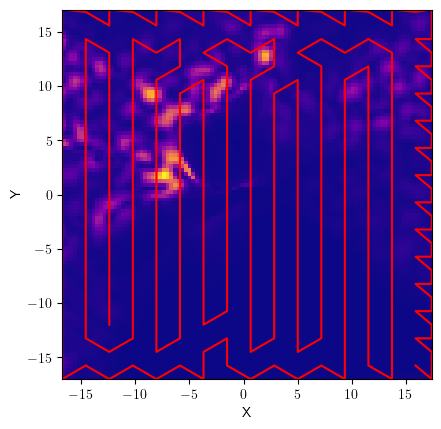

In [6]:
target_var_ratio = 2.2
max_prior_var = model.predict_f(X_grid)[1].numpy().max()
var_threshold = max_prior_var * target_var_ratio

method = 'HexCover'
cmodel = get_method(method)(num_sensing=len(X_train),
                            X_objective=X_train,
                            kernel=kernel,
                            noise_variance=noise_variance)
X_sol = cmodel.optimize(post_var_threshold=var_threshold)
X_sol = X_sol[0]

X_pred, y_pred = dataset.get_sensor_data(X_sol,
                                         max_samples=len(X_sol))
_, _, _, model_sol = get_model_params(
    X_train=np.vstack([X_train, X_pred]), 
    y_train=np.vstack([y_train, y_pred]), 
    kernel=kernel,
    noise_variance=noise_variance,
    max_steps=0,
    return_model=True,
    verbose=False,
    force_gp=True)
mean, var = model_sol.predict_f(X_grid)
distance = get_distance(X_sol)

# Create subplots
print(f"{method}; Distance: {distance:.0f} m; Mean Variance: {var.numpy().mean():.2f}")

fig = plt.figure()
axes = plt.gca()

sc = axes.imshow(var.numpy().reshape(x_dim, y_dim).T, 
                 extent=extent, origin="lower",
                 cmap='plasma')
axes.plot(X_sol[:, 0], X_sol[:, 1], c='r')
axes.set_aspect('equal')
axes.set_xlabel('X')
axes.set_ylabel('Y')
axes.set_xlim(extent[0], extent[1])
axes.set_ylim(extent[2], extent[3])

fig.savefig('HexCover', dpi=300, bbox_inches="tight")
plt.show()

ContinuousSGP; Distance: 302 m; Mean Variance: 0.02


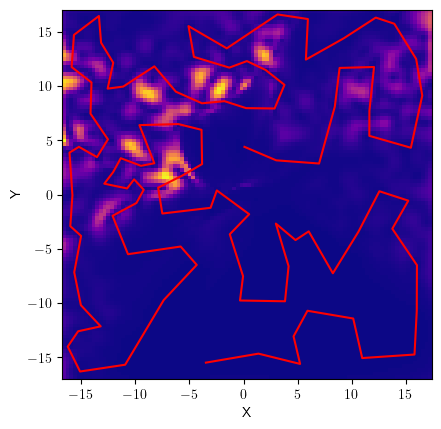

In [7]:
method = 'ContinuousSGP'
cmodel = get_method(method)(num_sensing=100,
                            X_objective=X_train,
                            kernel=kernel,
                            noise_variance=noise_variance)
X_sol = cmodel.optimize()
X_sol = X_sol[0]
X_sol, _ = run_tsp(X_sol)
X_sol = X_sol[0]

X_pred, y_pred = dataset.get_sensor_data(X_sol,
                                         max_samples=len(X_sol))
_, _, _, model_sol = get_model_params(
    X_train=np.vstack([X_train, X_pred]), 
    y_train=np.vstack([y_train, y_pred]), 
    kernel=kernel,
    noise_variance=noise_variance,
    max_steps=0,
    return_model=True,
    verbose=False,
    force_gp=True)
mean, var = model_sol.predict_f(X_grid)
distance = get_distance(X_sol)

# Create subplots
print(f"{method}; Distance: {distance:.0f} m; Mean Variance: {var.numpy().mean():.2f}")

fig = plt.figure()
axes = plt.gca()

sc = axes.imshow(var.numpy().reshape(x_dim, y_dim).T, 
                 extent=extent, origin="lower",
                 cmap='plasma')
axes.plot(X_sol[:, 0], X_sol[:, 1], c='r')
axes.set_aspect('equal')
axes.set_xlabel('X')
axes.set_ylabel('Y')
axes.set_xlim(extent[0], extent[1])
axes.set_ylim(extent[2], extent[3])

fig.savefig('SGP', dpi=300, bbox_inches="tight")
plt.show()

GreedyCover; Distance: 285 m; Mean Variance: 0.02


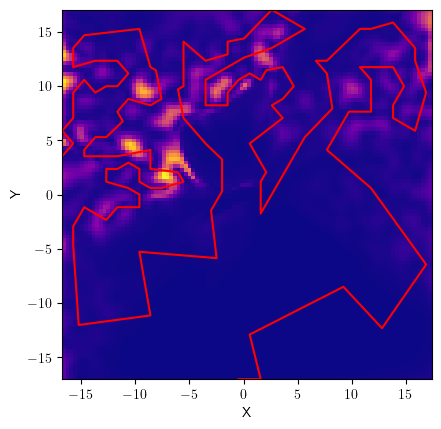

In [8]:
target_var_ratio = 0.9
max_prior_var = model.predict_f(X_grid)[1].numpy().max()
var_threshold = max_prior_var * target_var_ratio

method = 'GreedyCover'
cmodel = get_method(method)(num_sensing=len(X_train),
                            X_objective=X_train,
                            kernel=kernel,
                            noise_variance=noise_variance)
X_sol = cmodel.optimize(post_var_threshold=var_threshold)
X_sol = X_sol[0]

X_pred, y_pred = dataset.get_sensor_data(X_sol,
                                         max_samples=len(X_sol))
_, _, _, model_sol = get_model_params(
    X_train=np.vstack([X_train, X_pred]), 
    y_train=np.vstack([y_train, y_pred]), 
    kernel=kernel,
    noise_variance=noise_variance,
    max_steps=0,
    return_model=True,
    verbose=False,
    force_gp=True)
mean, var = model_sol.predict_f(X_grid)
distance = get_distance(X_sol)

# Create subplots
print(f"{method}; Distance: {distance:.0f} m; Mean Variance: {var.numpy().mean():.2f}")

fig = plt.figure()
axes = plt.gca()

sc = axes.imshow(var.numpy().reshape(x_dim, y_dim).T, 
                 extent=extent, origin="lower",
                 cmap='plasma')
axes.plot(X_sol[:, 0], X_sol[:, 1], c='r')
axes.set_aspect('equal')
axes.set_xlabel('X')
axes.set_ylabel('Y')
axes.set_xlim(extent[0], extent[1])
axes.set_ylim(extent[2], extent[3])

fig.savefig('GreedyCover', dpi=300, bbox_inches="tight")
plt.show()